In [231]:
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
import gzip
import time
from collections import OrderedDict

In [232]:
# mnist의 train_data, test_data 가져오기
# data/mnist 폴더 안에 gz 파일들을 넣어줘야 동작한다.
def load_mnist(train_data=True, test_data=False):

        RESOURCES = [
            'train-images-idx3-ubyte.gz',
            'train-labels-idx1-ubyte.gz',
            't10k-images-idx3-ubyte.gz',
            't10k-labels-idx1-ubyte.gz']

        if (os.path.isdir('data') == 0):
            os.mkdir('data')
        if (os.path.isdir('data/mnist') == 0):
            os.mkdir('data/mnist')
        for name in RESOURCES:
            if (os.path.isfile('data/mnist/'+name) == 0):
                url = 'http://yann.lecun.com/exdb/mnist/'+name
                r = requests.get(url, allow_redirects=True)
                open('data/mnist/'+name, 'wb').write(r.content)

        return get_images(train_data, test_data), get_labels(train_data, test_data)

def get_images(train_data=True, test_data=False):

        to_return = []

        if train_data:
            with gzip.open('data/mnist/train-images-idx3-ubyte.gz', 'r') as f:
                # first 4 bytes is a magic number
                magic_number = int.from_bytes(f.read(4), 'big')
                # second 4 bytes is the number of images
                image_count = int.from_bytes(f.read(4), 'big')
                # third 4 bytes is the row count
                row_count = int.from_bytes(f.read(4), 'big')
                # fourth 4 bytes is the column count
                column_count = int.from_bytes(f.read(4), 'big')
                # rest is the image pixel data, each pixel is stored as an unsigned byte
                # pixel values are 0 to 255
                image_data = f.read()
                train_images = np.frombuffer(image_data, dtype=np.uint8)\
                    .reshape((image_count, row_count, column_count))
                to_return.append(np.where(train_images > 127, 1, 0))

        if test_data:
            with gzip.open('data/mnist/t10k-images-idx3-ubyte.gz', 'r') as f:
                # first 4 bytes is a magic number
                magic_number = int.from_bytes(f.read(4), 'big')
                # second 4 bytes is the number of images
                image_count = int.from_bytes(f.read(4), 'big')
                # third 4 bytes is the row count
                row_count = int.from_bytes(f.read(4), 'big')
                # fourth 4 bytes is the column count
                column_count = int.from_bytes(f.read(4), 'big')
                # rest is the image pixel data, each pixel is stored as an unsigned byte
                # pixel values are 0 to 255
                image_data = f.read()
                test_images = np.frombuffer(image_data, dtype=np.uint8)\
                    .reshape((image_count, row_count, column_count))
                to_return.append(np.where(test_images > 127, 1, 0))

        return to_return

def get_labels(train_data=True, test_data=False):

        to_return = []

        if train_data:
            with gzip.open('data/mnist/train-labels-idx1-ubyte.gz', 'r') as f:
                # first 4 bytes is a magic number
                magic_number = int.from_bytes(f.read(4), 'big')
                # second 4 bytes is the number of labels
                label_count = int.from_bytes(f.read(4), 'big')
                # rest is the label data, each label is stored as unsigned byte
                # label values are 0 to 9
                label_data = f.read()
                train_labels = np.frombuffer(label_data, dtype=np.uint8)
                to_return.append(train_labels)
        if test_data:
            with gzip.open('data/mnist/t10k-labels-idx1-ubyte.gz', 'r') as f:
                # first 4 bytes is a magic number
                magic_number = int.from_bytes(f.read(4), 'big')
                # second 4 bytes is the number of labels
                label_count = int.from_bytes(f.read(4), 'big')
                # rest is the label data, each label is stored as unsigned byte
                # label values are 0 to 9
                label_data = f.read()
                test_labels = np.frombuffer(label_data, dtype=np.uint8)
                to_return.append(test_labels)

        return to_return

In [233]:
x_train, t_train = load_mnist(train_data=True, test_data=False)   # mnist의 train_images, train_labels 가져오기
x_test, test_labels = load_mnist(train_data=False, test_data=True) # test_images, test_labels



x_train= np.array(x_train).reshape(60000,784) # 처음 데이터 가져오면 28*28로 저장되어있어서 60000개 데이터를 1차원으로 변환

t_train=np.array(t_train).flatten() # t_train을 1차원으로 변환

def func(X):   # 1차원 데이터 labels 가공하는 함수
    new = np.zeros((X.size, 10))
    for idx, row in enumerate(new):
        row[X[idx]] = 1

    return new

t_train= func(t_train)

x_test = np.array(x_test).reshape(10000,784) # 10000개 데이터를 1차원으로 변환

test_labels = np.array(test_labels).flatten() # 1차원 데이터로 가공
test_labels = func(test_labels)


In [234]:
class Affine:  #행렬의 곱을 계산할때 사용
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self, x): # 순전파
        self.x = x
        out = np.dot(x, self.W) + self.b
        
        return out
    
    def backward(self, dout): #역전파
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis = 0)
        
        return dx

class Sigmoid:  #시그모이드 
    def __init__(self):
        self.out = None
    
    def forward(self, x): #순전파
        out = 1 / (1 + np.exp(-x))
        self.out = out
        
        return out
    
    def backward(self, dout): #역전파
        dx = dout * (1.0 - self.out) * self.out
        return dx
    
def sigmoid(x): #시그모이드 단순계산
    return 1 / (1+np.exp(-x))

def MSE(y, t): # Mean-Square-Error 
    return 0.5 * np.sum((y-t)**2)

class SigmoidmaxWithLoss: #시그모이드 with loss
    def __init__(self):
        self.loss = None   # Loss
        self.y = None      # Output
        self.t = None      # Target
        
    def forward(self, x, t): #순전파
        self.t = t
        self.y = sigmoid(x)
        self.loss = MSE(self.y, self.t) 
        return self.loss
    
    def backward(self, dout=1): #역전파
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

class TwoLayerNet:  # 입력~은닉, 은닉~출력 층이라 2개로 취급 but 실제로는 3개의 층
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size) # 입력~은닉층 weight
        self.params['b1'] = np.zeros(hidden_size) # 입력~은닉층 bias
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) #은닉~출력층 weight
        self.params['b2'] = np.zeros(output_size) #은닉~출력층 bias
        
        # Build Layers
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['sigmoid'] = Sigmoid()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        
        self.lastLayer = SigmoidmaxWithLoss()
    
    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
        
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 :
            t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y==t) / float(x.shape[0])
        return accuracy
    
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads
    
    def gradient(self, x, t):
        # foward
        self.loss(x, t)
        
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        return grads


In [235]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)  #input_node : 784, hidden_node : 50, output_node : 10

iters_num = 20000  # 반복횟수

train_size = np.array(x_train).shape[0]

batch_size = 60

train_loss_list = [] #에러가 들어있는 리스트
train_acc_list = []  #train 학습 정확도
test_acc_list = []   #test 학습 정확도

iter_per_epoch = max(train_size / batch_size, 1) # iter = 1000


In [236]:
epoch = 0
learning_rate = 0.1
start = time.time() #시작 시간

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    

    grad = network.gradient(x_batch, t_batch)

    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]  #SGD 

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss) #에러값 리스트에 저장
    
    
    if i % iter_per_epoch == 0:  #epoch마다 정확도 출력
        epoch += 1
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, test_labels)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print('Epoch', epoch, ':  ',train_acc,'\t', test_acc)

print("실행시간 :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간


Epoch 1 :   0.09953333333333333 	 0.1
Epoch 2 :   0.8619 	 0.8704
Epoch 3 :   0.8999333333333334 	 0.9034
Epoch 4 :   0.9115 	 0.9163
Epoch 5 :   0.9190666666666667 	 0.9223
Epoch 6 :   0.9266 	 0.9267
Epoch 7 :   0.9326833333333333 	 0.9322
Epoch 8 :   0.9373 	 0.9359
Epoch 9 :   0.9425666666666667 	 0.9408
Epoch 10 :   0.94505 	 0.9439
Epoch 11 :   0.9482833333333334 	 0.9474
Epoch 12 :   0.9506333333333333 	 0.9486
Epoch 13 :   0.9525833333333333 	 0.9506
Epoch 14 :   0.9557666666666667 	 0.9534
Epoch 15 :   0.9576166666666667 	 0.954
Epoch 16 :   0.95975 	 0.9565
Epoch 17 :   0.9615333333333334 	 0.9575
Epoch 18 :   0.9631333333333333 	 0.9591
Epoch 19 :   0.9643666666666667 	 0.9598
Epoch 20 :   0.9664333333333334 	 0.9604
실행시간 : 32.606788873672485


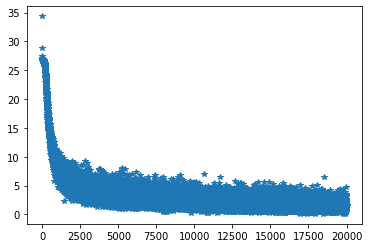

In [237]:
plt.plot(range(iters_num),train_loss_list,'*')